In [2069]:
import tensorflow as tf
from tensorflow.contrib import rnn
import tensorflow.contrib.legacy_seq2seq as s2s
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import importlib
import scipy

In [2070]:
with open('bmi_steps_data.pickle', 'rb') as f:
    bmi_steps = pd.DataFrame(pickle.load(f))

In [2071]:
plt = importlib.reload(plt)
plt.xticks

<function matplotlib.pyplot.xticks>

# Create training and test data
## And compute correlations between bmi and steps

In [2072]:
def get_data(input_type=['bmi', 'steps'], output_type=['bmi']):
    learning_data = []
    bs_correlations = []
    bmi_steps.groupby(
            ['user_id', 'year', 'month'])['bmi', 'steps'].agg('mean')
    s_mi =  bmi_steps.steps.mean()
    s_std = bmi_steps.steps.std()
    b_mi =  bmi_steps.bmi.mean()
    b_std = bmi_steps.bmi.std()
    i=0
    for user_id in bmi_steps.user_id.unique():
        # Select current user_id 
        user_bmi_steps = bmi_steps[bmi_steps.user_id == user_id]

        # Group user data by year/month and take average values of bmi and steps
        bmi_steps_month = user_bmi_steps.groupby(
            ['year', 'month'])['bmi', 'steps'].agg('mean')


        # Normalize steps values
        #s_mi =  bmi_steps_month.steps.mean()
        #s_std = bmi_steps_month.steps.std()
        bmi_steps_month.steps = bmi_steps_month.steps.apply(lambda x: (x - s_mi)/s_std)

        # Normalize bmi values
        #mi =  bmi_steps_month.bmi.mean()
        #std = bmi_steps_month.bmi.std()
        if b_std == 0:
            print('std is null')
            continue
        else:
            bmi_steps_month.bmi = bmi_steps_month.bmi.apply(lambda x: (x - b_mi)/b_std)

        # Compute bmi steps correlation
        bs_correlations.append({
            user_id: bmi_steps_month.corr()['bmi']['steps']})

        # Convert data into array that can be brokem into training 'batches'
        # that we will feed into our RNN model. Note the shape of arrays.
        bmi_steps_array = np.array(bmi_steps_month)

        # Sequence length
        n_observations = 1

        n_batches = len(bmi_steps_array) // n_observations

        # At least two samples should reserved for test:
        # one as input, another as value to predict
        if len(bmi_steps_array) % n_observations < 2:
            n_batches = n_batches - 1

        # Number of training samples
        n_training_samples = n_batches*n_observations

        # Input data 
        if ('bmi' in input_type) and ('steps' in input_type):
            x_data = np.array([ bmi_steps_array[i] for i in range(0, n_training_samples)])
            x_test = np.array([bmi_steps_array[i]
                           for i in range(n_training_samples, len(bmi_steps_array))])

        elif 'bmi' in input_type:
            x_data = np.array([ bmi_steps_array[i,0] for i in range(0, n_training_samples)])
            x_test = np.array([bmi_steps_array[i,0]
                           for i in range(n_training_samples, len(bmi_steps_array))])
        elif 'steps' in input_type:
            x_data = np.array([ bmi_steps_array[i,1] for i in range(0, n_training_samples)])
            x_test = np.array([bmi_steps_array[i,0]
                           for i in range(n_training_samples, len(bmi_steps_array))])


        # Output data
        if ('bmi' in input_type) and ('steps' in input_type):
            y_data = np.array([ bmi_steps_array[i] for i in range(0, n_training_samples)])
            y_test = np.array([bmi_steps_array[i]
                           for i in range(n_training_samples, len(bmi_steps_array))])

        elif 'bmi' in input_type:
            y_data = np.array([ bmi_steps_array[i,0] for i in range(0, n_training_samples)])
            y_test = np.array([bmi_steps_array[i,0]
                           for i in range(n_training_samples, len(bmi_steps_array))])
        elif 'steps' in input_type:
            y_data = np.array([ bmi_steps_array[i,1] for i in range(0, n_training_samples)])
            y_test = np.array([bmi_steps_array[i,0]
                           for i in range(n_training_samples, len(bmi_steps_array))])
#        if ('bmi' in output_type) and ('steps' in output_type):
#            y_data = bmi_steps_array[1: n_training_samples + 1]
#            y_test = np.array([bmi_steps_array[i]
#                           for i in range(n_training_samples + 1, len(bmi_steps_array))])
#        elif 'bmi' in output_type:
#            y_data = bmi_steps_array[1: n_training_samples + 1,0]
#            y_test = np.array([bmi_steps_array[i][0] 
#                           for i in range(n_training_samples + 1, len(bmi_steps_array))])
#        elif 'steps' in output_type:
#            y_data = bmi_steps_array[1: n_training_samples + 1,1]
#            y_test = np.array([bmi_steps_array[i][1] 
#                           for i in range(n_training_samples + 1, len(bmi_steps_array))])

        x_batches = x_data.reshape(-1,n_observations,len(input_type)) 
        y_batches = y_data.reshape(-1,n_observations,len(output_type))
        x_test = x_test.reshape(-1, len(bmi_steps_array) - n_training_samples, len(input_type))
        y_test = y_test.reshape(-1, len(bmi_steps_array) - n_training_samples, len(output_type))

        learning_data.append({
            'user_id': user_id,
            'n_training_samples': n_training_samples,
            'n_samples': len(bmi_steps_array),
            'n_observations': n_observations,
            'x_batches': x_batches,
            'y_batches': y_batches,
            'x_test': x_test,
            'y_test': y_test,
            'bmi_mean': mi,
            'bmi_std': std,
            'steps_mean': s_mi,
            'steps_std': s_std
        })
    return learning_data, bs_correlations

In [2073]:
learning_data, bs_correlations = get_data(
    input_type=['bmi'], output_type=['bmi'])

In [2074]:
len(learning_data)

87

In [2075]:
learning_data

[{'bmi_mean': 13412.601962481962,
  'bmi_std': 4728.117683130216,
  'n_observations': 1,
  'n_samples': 7,
  'n_training_samples': 6,
  'steps_mean': 10177.86308715721,
  'steps_std': 5902.665773591845,
  'user_id': '028b72dc-ca49-4e14-aed4-a792d39c01e0',
  'x_batches': array([[[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]]]),
  'x_test': array([[[ 0.42025703]]]),
  'y_batches': array([[[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]],
  
         [[ 0.42025703]]]),
  'y_test': array([[[ 0.42025703]]])},
 {'bmi_mean': 13412.601962481962,
  'bmi_std': 4728.117683130216,
  'n_observations': 1,
  'n_samples': 9,
  'n_training_samples': 8,
  'steps_mean': 10177.86308715721,
  'steps_std': 5902.665773591845,
  'user_id': '06d360b0-ea62-4912-bc6d-f3df0bea1fd8',
  'x_batches': array([[[-1.52661458]],


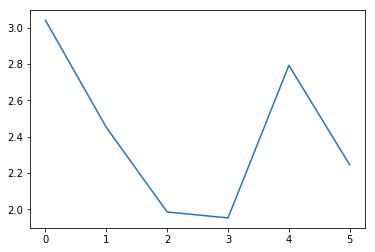

In [2051]:
plt.plot([d[0] for d in learning_data[0]['x_batches']])
plt.show()

## Get max and min correlations

In [2076]:
correlations = np.array([ list(d.values())[0] for d in bs_correlations])
print(correlations.max(), correlations.min(), correlations.mean(), np.median(correlations))
for c in bs_correlations:
    k = list(c.keys())[0]
    v = list(c.values())[0]
    if v == correlations.max():
        users_max = k
    if v == correlations.min():
        users_min = k
print(users_max)
print(users_min)

0.903207929202 -0.903678896516 -0.102049868646 -0.0935980645969
b38d0b04-b431-48ea-a75e-58269b92e0c1
18be7e4e-c005-4a40-b993-e37e997e4a31


## Visualize max and min correlations

                  bmi         steps
year month                         
2014 9      28.245061  17073.000000
     10     27.819578  14867.275862
     11     27.580043  14440.080000
     12     26.996661  13459.761905
2015 1      26.996661  13806.687500
     4      26.996661  14540.500000
     5      26.996661  13562.320000
     6      26.996661  13623.555556
     7      26.996661  13747.700000
            bmi     steps
bmi    1.000000  0.903208
steps  0.903208  1.000000


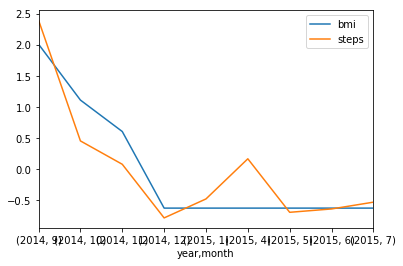

In [2047]:
group = bmi_steps[bmi_steps.user_id == users_max].groupby(
    ['year','month'])['bmi', 'steps'].agg('mean')
print(group)
print(group.corr())
mi =  group.steps.mean()
std = group.steps.std()
group.steps = group.steps.apply(lambda x: (x - mi)/std)
mi =  group.bmi.mean()
std = group.bmi.std()
group.bmi = group.bmi.apply(lambda x: (x - mi)/std)
group.plot()
plt.show()

                  bmi         steps
year month                         
2016 8      28.842228  10205.578947
     9      28.901146  11571.037037
     10     29.314337  10460.434783
     11     29.823528   8885.357143
     12     30.346910   8715.100000
2017 1      30.892604   8172.800000
            bmi     steps
bmi    1.000000 -0.903679
steps -0.903679  1.000000


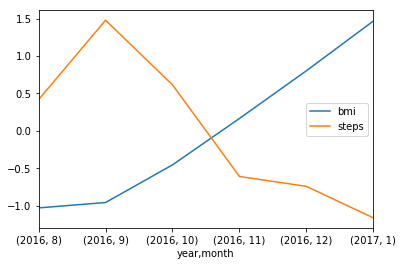

In [2046]:
group = bmi_steps[bmi_steps.user_id == users_min].groupby(
    ['year','month'])['bmi', 'steps'].agg('mean')
print(group)
print(group.corr())
mi =  group.steps.mean()
std = group.steps.std()
group.steps = group.steps.apply(lambda x: (x - mi)/std)
mi =  group.bmi.mean()
std = group.bmi.std()
group.bmi = group.bmi.apply(lambda x: (x - mi)/std)
group.plot()
plt.show()

## Data example

In [2048]:
learning_data[0]

{'bmi_mean': 9200.451936234263,
 'bmi_std': 3365.650580655681,
 'n_observations': 1,
 'n_samples': 7,
 'n_training_samples': 6,
 'steps_mean': 10177.86308715721,
 'steps_std': 5902.665773591845,
 'user_id': '028b72dc-ca49-4e14-aed4-a792d39c01e0',
 'x_batches': array([[[ 3.04032021]],
 
        [[ 2.45148784]],
 
        [[ 1.98594323]],
 
        [[ 1.9532339 ]],
 
        [[ 2.79229265]],
 
        [[ 2.24443284]]]),
 'x_test': array([[[ 0.42025703]]]),
 'y_batches': array([[[ 3.04032021]],
 
        [[ 2.45148784]],
 
        [[ 1.98594323]],
 
        [[ 1.9532339 ]],
 
        [[ 2.79229265]],
 
        [[ 2.24443284]]]),
 'y_test': array([[[ 0.42025703]]])}

# Set up tensorflow graph

TypeError: Expected int for argument 'num' not <tf.Tensor 'mul:0' shape=() dtype=int32>.

In [1863]:
learning_data[0]['x_batches'].shape

(2, 2, 1)

# Function to launch RNN

In [2052]:
def launch_graph(training_dict, epochs=2000):
    tf.reset_default_graph()
    
    # Parameters
    learning_rate = 0.001
    global_step = tf.Variable(0, trainable=False)
    start_learning_rate = 0.01
    end_learning_rate = 0.001
    decay_steps = 1000
    batch_size = training_dict['x_batches'].shape[0]
    seq_len = training_dict['x_batches'].shape[1]

    n_input = 1 # bmi, steps
    n_hidden = 10 # num of hidden nodes
    n_output = 1 # bmi

    # tf Graph input
    x = tf.placeholder("float", [batch_size, seq_len, n_input])
    y = tf.placeholder("float", [batch_size, seq_len, n_output])
    b = tf.shape(x)[1]
    
    
    # Define a lstm cell with tensorflow
    # lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # lstm_cell = rnn.BasicRNNCell(num_units=n_hidden, activation=tf.nn.relu)
    lstm_cell = rnn.BasicLSTMCell(n_hidden, activation=tf.nn.tanh)
 
    #lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell, output_keep_prob=0.8)

    # Get lstm cell output
    # rnn_output, states = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)

    rnn_output, states = s2s.basic_rnn_seq2seq(
        tf.unstack(x), 
        tf.unstack(y), 
        lstm_cell)


    # Densely connected output layer
    # Reshape the rnn output to feed the output layer
    stacked_rnn_output = tf.reshape(rnn_output, [-1, n_hidden])
    outputs = tf.layers.dense(stacked_rnn_output, n_output)
    outputs = tf.reshape(outputs, [-1, b, n_output])

    # Define cost function (mse)
    cost = tf.reduce_sum(tf.square(outputs-y)) 

    # Define the optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        cost, global_step=global_step)


    # Initializing the variables
    init = tf.global_variables_initializer()
    
    
    # Launch the graph
    fdict = {x: training_dict['x_batches'], y: training_dict['y_batches']}
    with tf.Session() as sess:
        sess.run(init)
        for ep in range(epochs):
            _, outH, outY = sess.run([optimizer, states, outputs], 
                                     feed_dict=fdict)
                 # batch_costs.append(err)
            # if summary is not None:
            #     writer.add_summary(summary, i)
            #costs.append(np.average(batch_costs, axis=0))
            

            if ep % 1000 == 0:
                mse = cost.eval(feed_dict=fdict)
                print (ep, "\tMSE= ", mse)
                #print (ep, "\tlearning rate = ", lr)
        print ("Optimization Finished!")
        #mse = cost.eval(feed_dict=training_dict)
        #y_pred = sess.run([outputs], feed_dict=test_dict)
        return(outH, outY, y_pred, mse)

    

# Run RNN for each user

In [2054]:
exp = 6
results = []
i = 0
for data in learning_data:
    #print('user_id: ', data['user_id'])
    #print('n_observations: ', data['n_observations'])
    outH, outY, y_pred, mse = launch_graph({'x_batches': data['x_batches'], 
                                            'y_batches': data['y_batches']},  
                                           2001)
    results.append({
        'user_id': data['user_id'],
        'outH': outH,
        'outY': outY,
        'targetY': data['y_batches'],
        'y_pred': y_pred, 
        'y_test': data['y_test'], 
        'mse': mse,
        'n_samples': data['n_samples'],
        'n_training_samples': data['n_training_samples'],
        'bmi_mean': data['bmi_mean'],
        'bmi_std': data['bmi_std'],
        'steps_mean': data['steps_mean'],
        'steps_std': data['steps_std'],
    })
    i = i+1
    
with open('rnn_bmi_steps_results_{}.pickle'.format(exp), 'wb') as f:
    pickle.dump(results, f)
    

0 	MSE=  27.8569
1000 	MSE=  0.141987
2000 	MSE=  0.0084434
Optimization Finished!
0 	MSE=  6.62298
1000 	MSE=  0.0179376
2000 	MSE=  0.000445792
Optimization Finished!
0 	MSE=  21.101
1000 	MSE=  0.0905698
2000 	MSE=  0.0153311
Optimization Finished!
0 	MSE=  7.75836
1000 	MSE=  0.00507293
2000 	MSE=  1.92904e-05
Optimization Finished!
0 	MSE=  0.421466
1000 	MSE=  2.63108e-08
2000 	MSE=  2.03067e-14
Optimization Finished!
0 	MSE=  6.68336
1000 	MSE=  0.00135028
2000 	MSE=  0.000524812
Optimization Finished!
0 	MSE=  3.95726
1000 	MSE=  0.000107505
2000 	MSE=  3.9695e-05
Optimization Finished!
0 	MSE=  0.152566
1000 	MSE=  5.04362e-13
2000 	MSE=  3.83591e-16
Optimization Finished!
0 	MSE=  4.95033
1000 	MSE=  0.000201779
2000 	MSE=  1.72718e-06
Optimization Finished!
0 	MSE=  8.35817
1000 	MSE=  0.0148425
2000 	MSE=  0.00398811
Optimization Finished!
0 	MSE=  0.412688
1000 	MSE=  3.04884e-08
2000 	MSE=  4.57412e-14
Optimization Finished!
0 	MSE=  10.1029
1000 	MSE=  7.05391e-05
2000 	

In [2017]:
results[0]

{'bmi_mean': 30.068832266634452,
 'bmi_std': 4.1023203976182695e-15,
 'mse': 1.6542323e-13,
 'n_samples': 7,
 'n_training_samples': 6,
 'outH': LSTMStateTuple(c=array([[-2.38361168,  0.41595972,  0.1029115 ,  1.67051041,  1.32408774,
        -1.52062726, -3.58939123,  0.96726644,  0.33312166, -1.92275405]], dtype=float32), h=array([[-0.47270855,  0.28473952,  0.08100425,  0.63139868,  0.5744254 ,
        -0.52425456, -0.69402891,  0.59830534,  0.24401724, -0.51534456]], dtype=float32)),
 'outY': array([[[ 0.99507809]],
 
        [[-0.15658629]],
 
        [[-1.06711912]],
 
        [[-1.13109326]],
 
        [[ 0.50997454]],
 
        [[-0.56155372]]], dtype=float32),
 'steps_mean': 25120.74845271442,
 'steps_std': 3017.9631103208835,
 'targetY': array([[[ 0.995078  ]],
 
        [[-0.1565864 ]],
 
        [[-1.06711915]],
 
        [[-1.1310935 ]],
 
        [[ 0.50997472]],
 
        [[-0.56155373]]]),
 'user_id': '028b72dc-ca49-4e14-aed4-a792d39c01e0',
 'y_pred': [array([[[-0.346725

## Save training results

In [ ]:
with open('rnn_bmi_steps_results.pickle', 'wb') as f:
    pickle.dump(results, f)

# Function to plot target and predicted outputs

In [2008]:
def plot_outputs(results, idx): 
    x_labels = [str(tuple(x)) for x in bmi_steps[['year', 'month']].loc[
         bmi_steps.user_id==results[idx]['user_id']].drop_duplicates().values]
    mi = results[idx]['bmi_mean'] 
    std = results[idx]['bmi_std'] 
    targets_train = [r[0]*std + mi
                     for r in results[idx]['targetY'].reshape(
                         -1,results[idx]['n_training_samples'],1)[0]]
    targets_test = [r[0]*std + mi
                    for r in results[idx]['y_test'][0]]
    targets = targets_train + targets_test
    print(targets)
    
    pred_train = [r[0]*std + mi
                  for r in results[idx]['outY'].reshape(
        -1,results[idx]['n_training_samples'],1)[0]]
    pred_test = [r[0]*std + mi
                 for r in results[idx]['y_pred'][0][0]]
    predicted = pred_train + pred_test
    print(predicted)
    print(plt.xticks)
    x = [i for i in range(len(targets))]
    plt.xticks(x, x_labels, rotation='vertical')
    plt.plot(targets, label='target')
    plt.plot(predicted, label='predicted')

    # plt.scatter(results[0]['y_pred'][0][0])
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 4), dpi=100)

In [1631]:
# Read training results
with open('rnn_bmi_steps_results_1.pickle', 'rb') as f:
    results = pickle.load(f)

In [2055]:
idx = 2
print(results[idx]['y_test'])
print(results[idx]['y_pred'][0][0])

[[[-1.11850787]]]
[[-0.34672555]]


[10850.585914193354, 11567.718540689732, 12160.118821411514, 11789.329562665294, 11177.954553225545, 12700.30039673497, 13217.91011837555, 13653.270429335449, 17275.583775357514, 5435.9452774410038]
[10850.431812643599, 11534.374481198012, 12225.933247935496, 11689.199235348886, 11418.007562376621, 12526.03359544145, 13059.778141542505, 13860.653845843703, 17223.646365102686, 8033.4948765289428]
<function xticks at 0x155b12620>


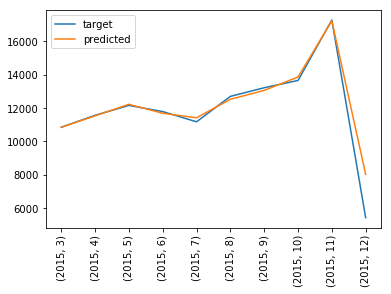

In [2056]:
plot_outputs(results, idx)

In [1901]:
errors = np.array([r['mse'] for r in results])
print(max(errors), min(errors), errors.mean())

0.0106782 7.99361e-15 0.00110754


In [2064]:
df_results = pd.DataFrame(results)

In [2065]:
[r[0] for r in results[idx]['y_test'][0][0]]

IndexError: invalid index to scalar variable.

In [2066]:
results[1]['outH'].h

array([[-0.5673793 , -0.48777997, -0.67855453, -0.41247547,  0.49827209,
         0.3696945 ,  0.47610503, -0.20668712, -0.35953319, -0.10932138]], dtype=float32)

In [2067]:
w = [results[i]['outH'].h[-1] for i in range(len(results))]

In [2058]:
w

[array([ 0.36805165, -0.58047134, -0.61942482,  0.52257311, -0.58294815,
         0.43322316, -0.59891653, -0.45185012,  0.76794392,  0.70136178], dtype=float32),
 array([-0.5673793 , -0.48777997, -0.67855453, -0.41247547,  0.49827209,
         0.3696945 ,  0.47610503, -0.20668712, -0.35953319, -0.10932138], dtype=float32),
 array([-0.78415304,  0.23036562,  0.11806071,  0.79693192,  0.37910861,
        -0.56198066, -0.13018449, -0.15482181,  0.69198263,  0.68365115], dtype=float32),
 array([ 0.41268569,  0.56291103, -0.53801447, -0.14566728,  0.19111373,
         0.14966284, -0.10746558,  0.59890485,  0.2953859 ,  0.43912491], dtype=float32),
 array([-0.01877106,  0.38526675, -0.35993308, -0.36878335, -0.00884945,
         0.11128487,  0.30134961,  0.24251911,  0.1573333 , -0.03307962], dtype=float32),
 array([ 0.46689585,  0.5983997 ,  0.48521796, -0.45173454,  0.05113642,
        -0.4515633 ,  0.41387683, -0.61581647, -0.55158019, -0.08420873], dtype=float32),
 array([ 0.51211298, -

In [1726]:
distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(w))

In [1728]:
idx_u, idx_n = distances[78].argsort()[:2]
print(idx_u, idx_n)

78 38


[ 0.34857094 -0.25100598  0.41357943 -0.40026942 -0.07772966  0.30386734
  0.21072428 -0.29745594 -0.56069374 -0.37435755]
                  bmi         steps
year month                         
2014 10     29.656229   8203.000000
     11     29.000010  14483.608696
     12     28.631619  13656.500000
2015 1      28.631619  16010.826087
     2      28.631619  15619.222222
     3      28.631619  19456.166667
     4      28.631619  13344.695652
     5      28.631619  14320.904762
     6      28.631619  16607.062500
     7      28.631619  12138.272727
     8      28.631619  13279.461538
     11     28.631619  29572.000000
2016 2      28.631619  15026.500000
     3      28.631619  15139.235294
     4      28.631619  16084.000000
     5      28.631619  16971.588235
     6      28.631619  17129.666667
     7      28.631619  16626.111111
     8      28.631619  15212.529412
     9      28.631619  16245.700000
     10     28.631619  16759.312500
     11     28.631619  18772.062500
     12     2

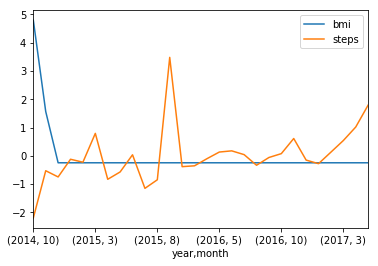

In [1729]:
print(w[idx_u])
group = bmi_steps[bmi_steps.user_id == df_results.iloc[idx_u]['user_id']].groupby(
    ['year','month'])['bmi', 'steps'].agg('mean')
print(group)
print(group.corr())
mi =  group.steps.mean()
std = group.steps.std()
group.steps = group.steps.apply(lambda x: (x - mi)/std)
mi =  group.bmi.mean()
std = group.bmi.std()
group.bmi = group.bmi.apply(lambda x: (x - mi)/std)
group.plot()
plt.show()
plt.figure(figsize=(10, 4), dpi=100)

[-0.10609838 -0.11046403  0.19249801 -0.03722573 -0.05309733  0.1887455
  0.08346626  0.12140364  0.20109305 -0.04486595  0.15948844 -0.07092375
 -0.06584074 -0.01596359  0.06807332  0.20627154 -0.03202019 -0.23570891
 -0.02097333  0.10084376]
                  bmi         steps
year month                         
2016 2      28.056552   6700.000000
     3      27.304589  12574.931034
     4      27.249306  11917.142857
     5      27.249306  14942.250000
     6      27.249306  16369.000000
     7      27.249306  13595.555556
     8      27.249306  11194.133333
     9      27.249306  14771.000000
            bmi     steps
bmi    1.000000 -0.827396
steps -0.827396  1.000000


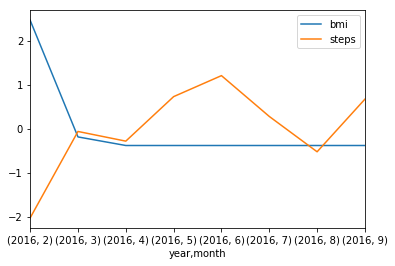

In [1690]:
print(w[idx_n])
group = bmi_steps[bmi_steps.user_id == df_results.iloc[idx_n]['user_id']].groupby(
    ['year','month'])['bmi', 'steps'].agg('mean')
print(group)
print(group.corr())
mi =  group.steps.mean()
std = group.steps.std()
group.steps = group.steps.apply(lambda x: (x - mi)/std)
mi =  group.bmi.mean()
std = group.bmi.std()
group.bmi = group.bmi.apply(lambda x: (x - mi)/std)
group.plot()
plt.show()
plt.figure(figsize=(10, 4), dpi=100)

In [2060]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4).fit(w)
distances, indices = nbrs.kneighbors(w)

In [2061]:
indices[28]

array([28, 60, 36, 75])

In [2062]:
max([max(d) for d in distances])

2.0519041073714601

[-0.52091414  0.28378388 -0.12663527  0.06644451 -0.38046092  0.24365631
 -0.39365315  0.46737707  0.22518937 -0.56852192]


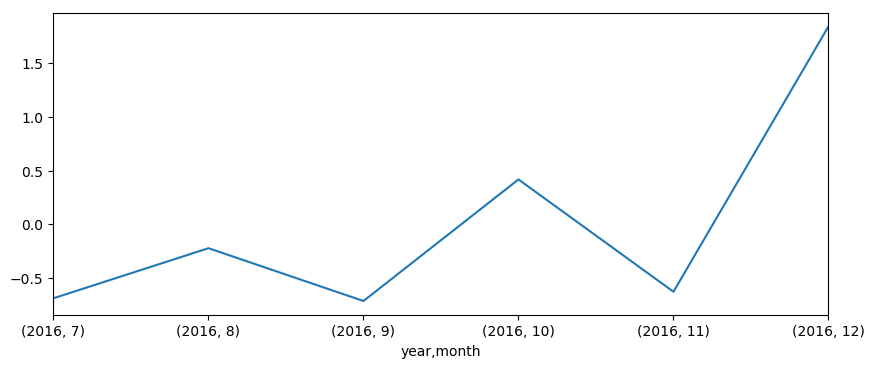

[-0.35331404  0.59024757  0.56447107  0.19603941  0.03390613  0.16069515
 -0.20297949  0.42948544  0.50066388 -0.58655047]


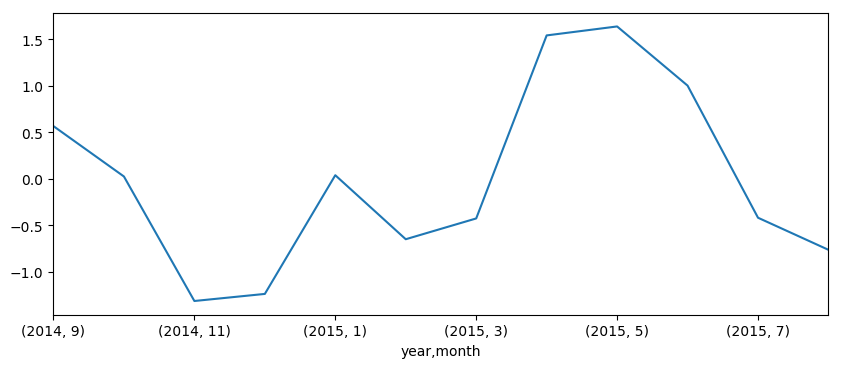

[-0.48508629  0.391258    0.56436837 -0.26251233 -0.60239851  0.13262504
  0.11117284  0.02045988  0.04016659 -0.56158245]


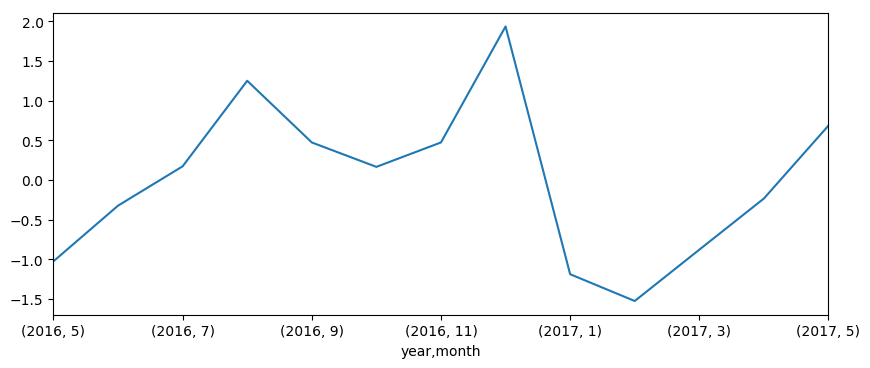

[-0.41864139 -0.37041059 -0.4692505  -0.39585418 -0.51466984  0.01053463
 -0.56179953  0.27232072 -0.27945727 -0.79709053]


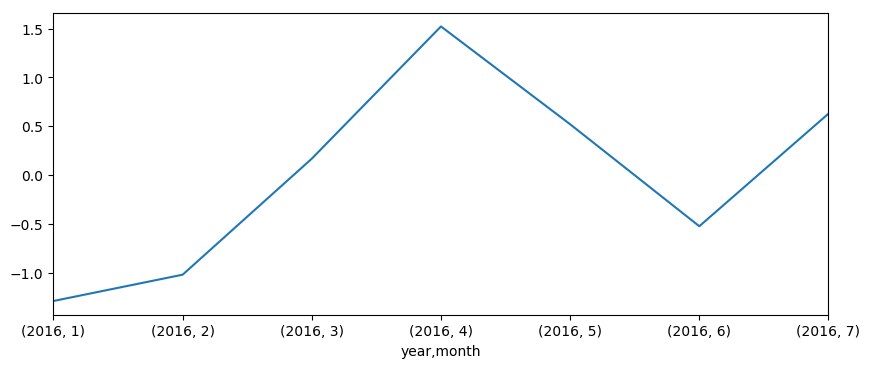

In [2068]:
for idx in indices[84]:    
    print(w[idx])
    #group = bmi_steps[bmi_steps.user_id == df_results.iloc[idx]['user_id']].groupby(
    #    ['year','month'])['bmi', 'steps'].agg('mean')
    group = bmi_steps[bmi_steps.user_id == df_results.iloc[idx]['user_id']].groupby(
        ['year','month'])['steps'].agg('mean')
    mi =  group.mean()
    std = group.std()
    group = group.apply(lambda x: (x - mi)/std)
    #print(group.corr())
    #mi =  group.steps.mean()
    #std = group.steps.std()
    #mi =  group.mean()
    #std = group.std()
    #group = group.apply(lambda x: (x - mi)/std)
    #mi =  group.bmi.mean()
    #std = group.bmi.std()
    #group.bmi = group.bmi.apply(lambda x: (x - mi)/std)
    group.plot()
    plt.show()
    plt.figure(figsize=(10, 4), dpi=100)

In [1418]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


3.82441 0.0 0.203135
